In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Jun 18 18:44:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.4 MB/s 


In [ ]:
! pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.9 MB/s 


In [ ]:
!pwd

/content


In [ ]:
% cd /content/drive/MyDrive/node_experiment/node/lib

/content/drive/MyDrive/node_experiment/node/lib


In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import category_encoders
%matplotlib inline
import lib
#from lib import Dataset
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'year_node_8layers'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

env: CUDA_VISIBLE_DEVICES=0


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


experiment: year_node_8layers_2022.06.18_18:44


In [ ]:
! ls

arch.py  data.py      logs	   odst.py	trainer.py
data	 __init__.py  nn_utils.py  __pycache__	utils.py


In [ ]:
!pwd

/content/drive/MyDrive/node_experiment/node/lib


In [ ]:
from lib import data as datalib
from lib import arch
from lib import nn_utils
from lib import utils
from lib import trainer as trainerlib

In [ ]:
#data = lib.Dataset("YEAR", random_state=1337, quantile_transform=True, quantile_noise=1e-3)
data = datalib.Dataset("YEAR", random_state=1337, quantile_transform=True, quantile_noise=1e-3)
in_features = data.X_train.shape[1]


mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid, data.y_test = map(normalize, [data.y_train, data.y_valid, data.y_test])

print("mean = %.5f, std = %.5f" % (mu, std))

mean = 1998.39193, std = 10.92832


In [ ]:
model = nn.Sequential(
    arch.DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=nn_utils.entmax15, bin_function=nn_utils.entmoid15),
    nn_utils.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:5000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

../lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)


In [ ]:
! pip install qhoptim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [ ]:
trainer = trainerlib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

Runs clean to this cell - June 17, 2022

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 5000
report_frequency = 100

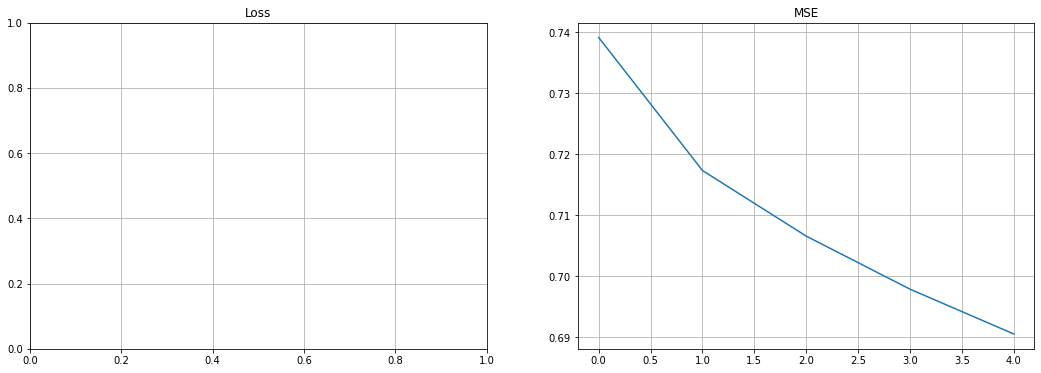

Loss 0.58622
Val MSE: 0.69054
stepper is  101


In [26]:
stepper = 0
for batch in utils.iterate_minibatches(data.X_train, data.y_train, batch_size=1024, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    loss_history.append(metrics['loss'])
    stepper = stepper +1
    print("stepper is ",stepper)
    if stepper > 100:
        break
    if trainer.step % report_frequency == 0:
        print("start if")
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            data.X_valid, data.y_valid, device=device, batch_size=16384)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        # This causes an error
        #plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [27]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(data.X_test, data.y_test, device=device)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))

Loaded logs/year_node_8layers_2022.06.18_18:44/checkpoint_best_mse.pth
Best step:  500
Test MSE: 0.68557


In [28]:
mse * std ** 2

81.87597799638806